In [1]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
from fastai import vision

In [5]:
# using personal API key
key = os.environ.get('AZURE_SEARCH_KEY', 'a66aa201bc75426189f0ea8b8286503f')

In [6]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
#len(ims)

150

In [7]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [8]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
fns = get_image_files(path)
fns

(#133) [Path('bears/grizzly/0121e466-5a1d-43d4-8d6e-de95119cf83c.jpg'),Path('bears/grizzly/3ce5ecfa-4255-40cb-9cd3-44ff902da406.jpg'),Path('bears/grizzly/909ef8bb-f485-498b-9641-121b08ccaa15.jpg'),Path('bears/grizzly/ab884a55-5077-453c-acfd-288dbd8b457e.jpg'),Path('bears/grizzly/a4f62956-7b4d-4fe8-bd70-9f085893ab51.jpg'),Path('bears/grizzly/7881006b-55a4-496f-bd6e-716d14653027.jpg'),Path('bears/grizzly/b3eb7a50-e2db-4ddc-a16f-b50ea866bf83.JPG'),Path('bears/grizzly/38eb46f3-2f6c-4484-a0a6-d957718be412.jpg'),Path('bears/grizzly/71fceafa-34a3-4e5a-a065-3d49e1caeb72.jpg'),Path('bears/grizzly/74a1768d-9105-43fa-b40a-e3545debc3d0.jpg')...]

In [10]:
#check for corrupt images
failed = verify_images(fns)
failed

(#0) []

In [11]:
#map corrupt images
failed.map(Path.unlink);

In [12]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [13]:
# Resizing options
#item_tfms=Resize(128, ResizeMethod.Squish)
#item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros')
#item_tfms=RandomResizedCrop(128, min_scale=0.3)


bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5))
dls = bears.dataloaders(path)

In [14]:
# this is a work around to download resnet and bypass SSL, not reccomended if possible
import ssl 
ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.951617,1.837798,0.615385,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.622929,1.069485,0.461538,00:03
1,1.453636,0.298956,0.115385,00:03
2,1.147126,0.160271,0.076923,00:03
3,0.889303,0.139698,0.038462,00:03


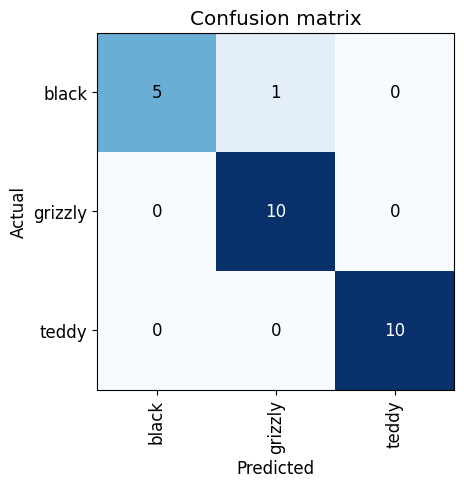

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

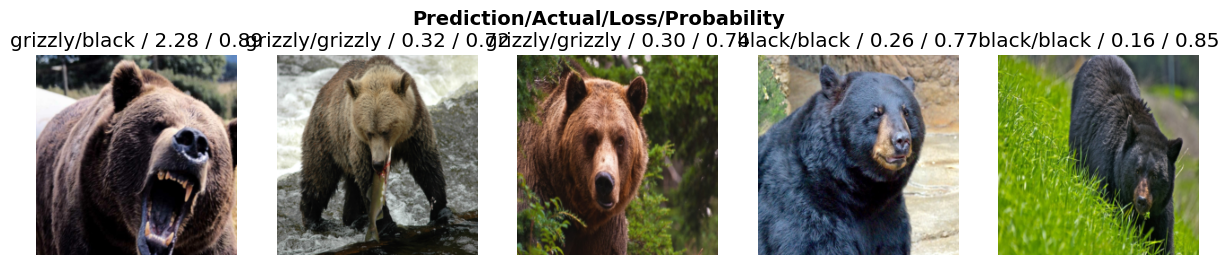

In [17]:
interp.plot_top_losses(5, nrows=1)

In [25]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [27]:
# export the model
learn.export()

In [28]:
# check file exists
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('grizzly.jpg')

('grizzly', tensor(1), tensor([1.0474e-01, 8.9480e-01, 4.6029e-04]))

In [31]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [54]:
# manual version
#btn_upload = SimpleNamespace(data = ['grizzly.jpg'])

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

[]

In [56]:
img = PILImage.create(btn_upload.data[-1])

In [58]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [59]:
pred,pred_idx,probs = learn_inf.predict(img)

In [60]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9999')